# Identifying bugs from launchpad

From the way Launchpad works the flow for a ticket opening in launchpad is:
1. a ticket, stating a possible bug, is opened in launchpad and its status is New,
2. if the problem stated in the ticket is reproduced than the bug is confirmed as genuine and the ticket status passes from New to Confirmed,
3. only when a bug is confirmed, the status then changes from Confirmed to In Progress in the same time that an issue that will try to solve the bug is opened in gerrit.

Tracing this flow, which data's can be extracted from the launchpad database, we can automatically identify the bugs...

In [1]:
# importing needed libraries and establishing a connection to the database
import MySQLdb
import pandas

def connect():
   user = "root"
   password = ""
   host = "localhost"
   db = "report_time"
   port=3306
   use_unicode=True

   try:
      db = MySQLdb.connect(user = user, passwd = password, db = db, port = port, use_unicode = use_unicode)
      return db, db.cursor()
   except:
      logging.error("Database connection error!")
      raise
        
def execute_query(connector, query):
   results = int (connector.execute(query))
   cont = 0
   if results > 0:
      result1 = connector.fetchall()
      return result1
   else:
      return []
    
db, cursor = connect()

In [3]:
# Let's extract number of projects affected by these tickets
cursor.execute(""" select distinct tracker_id
from tickets_2016.issues """)

242L

In [4]:
# Let's extract the total number of projects in Open Stack
cursor.execute(""" select distinct id
from tickets_2016.trackers """)

331L

## Result:
242 projects out of 331 in Open Stack are active. 
However, for the scope of this study, we will focus on the nine key components that are a part of 
the "core" of OpenStack, are distributed as a part of any OpenStack system, and officially maintained by the OpenStack community: Nova, Swift, Cinder, Neutron, Horizon, Keystone, Glance, Ceilometer, and Heat.   

# Extraction of the bugs in Open Stack

In [5]:
# Let's first see the number of the total tickets in Launchpad
cursor.execute(""" select id, issue
from tickets_2016.issues """)

99134L

In [6]:
# Now let's see how many of them are distinct tickets
cursor.execute(""" select distinct issue
from tickets_2016.issues """)

92910L

In [7]:
# Extracting the tickets from launchpad that do follow the flow: New -> Confirmed -> In progress. 
# Will store these datas in a table for facilitating later use. 
# Note: this datas contain duplicated issue
cursor.execute(""" create table confirmedLP_bugs as
select ie.id,
       ie.status, 
       ie.issue_id,
       i.issue,
       ie.title, 
       ie.description, 
       ie.web_link, 
       ie.date_created, 
       ie.date_confirmed, 
       ie.date_in_progress,
       i.tracker_id
from tickets_2016.issues_ext_launchpad ie
inner join tickets_2016.issues i
on ie.issue_id=i.id
where ie.date_confirmed != '' 
and ie.date_in_progress != ''
""")

/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'date_confirmed' at row 1
/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'date_in_progress' at row 1


64895L

In [9]:
# let's see how many of these are distinct issues
cursor.execute(""" select distinct issue from confirmedLP_bugs """)

61894L

## Results: 

(when we talk about tickets we are talking about reports)

1. 92910 tickets out of 99134 are distinct. This means that 9,4% of the total tickets are duplicated.
2. 64895 tickets out of 99134 are bugs. This means that 65.5% of the tickets are bugs.
3. Only 34,5% of the tickets are not clasified as bugs, have been abandoned for some reason, or are still New and being analysed.

## Analysis of the time from the moment the ticket first appears to launchpad to the moment it is confirmed as a bug. 

In [10]:
# time to confirm that a ticket is describing a bug - time to classify a ticket
query = """ select issue,
                   date_created,
                   date_confirmed,
                   timestampdiff(SECOND, date_created, date_confirmed) as time2classify,
                   tracker_id
            from confirmedLP_bugs """

In [11]:
data = execute_query(cursor, query)

In [12]:
data_list = list(data)

In [13]:
pandas_ds = pandas.DataFrame(data_list, columns=["issue", "date_created", "date_confirmed", "time2classify", "tracker_id"])
pandas_ds.columns.values.tolist()

['issue', 'date_created', 'date_confirmed', 'time2classify', 'tracker_id']

In [14]:
time2classify = pandas_ds["time2classify"]

In [15]:
#Some statistics about the time to classify the ticket
print "Mean Time for classifying a ticket: %f hours" % (time2classify.mean()/3600.0)
print "Median Time for classifying a ticket: %f hours" % (time2classify.median()/3600.0)
print "Quantiles: "
print time2classify.quantile([0.25, 0.5, 0.75])

Mean Time for classifying a ticket: 313.173732 hours
Median Time for classifying a ticket: 1.973611 hours
Quantiles: 
0.25       277.0
0.50      7105.0
0.75    260286.5
Name: time2classify, dtype: float64


Populating the interactive namespace from numpy and matplotlib


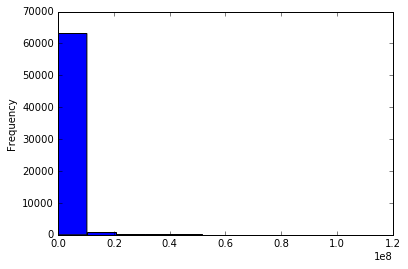

In [18]:
# Lets have a look at the boxplots without logaritmic scale
%pylab inline
pandas_ds["time2classify"].plot(kind="hist")

In [19]:
# select min time for classifying a ticket - time in seconds

pandas_ds['time2classify'].idxmin()

19

In [20]:
# select max time for classifying a ticket - time in seconds

pandas_ds['time2classify'].idxmax()

26525

## Results:

The minimum time for classifying a ticket is 19 sec (or 0.8 hours) while the maximum is 26615 sec (7,4 days).

# Analyse the distribution of bugs per number of tickets divided per OpenStack core projects

### 1. Nova

In [21]:
# the bugs found in Nova
cursor.execute(""" select * from confirmedLP_bugs 
where tracker_id=47 or 
tracker_id=136 or
tracker_id=137 or 
tracker_id=169 or 
tracker_id=200 or
tracker_id=227 or 
tracker_id=234 or
tracker_id=258 """)

8251L

In [22]:
# all the tickets related to Nova
cursor.execute(""" select * from tickets_2016.issues 
where tracker_id=47 or 
tracker_id=136 or
tracker_id=137 or 
tracker_id=169 or 
tracker_id=200 or
tracker_id=227 or 
tracker_id=234 or
tracker_id=258 """)

13554L

## Results:

In Nova - 8251 tickets out of 13554 are bugs. This means 60.9% of tickets are bugs.

## 2. Swift

In [23]:
# the bugs found in Swift
cursor.execute(""" select * from confirmedLP_bugs
where tracker_id=50 or 
tracker_id=173 or
tracker_id=203 or 
tracker_id=214 """)

1059L

In [25]:
# all the tickets related to Swift
cursor.execute(""" select * from tickets_2016.issues 
where tracker_id=50 or 
tracker_id=173 or
tracker_id=203 or 
tracker_id=214 """)

1809L

## Results:
In Swift - 1059 tickets out of 1809 are bugs. This means 58.5% of tickets are bugs.

## 3. Cinder

In [26]:
# the bugs found in Cinder
cursor.execute(""" select * from confirmedLP_bugs
where tracker_id=7 or 
tracker_id=156 or
tracker_id=182 or 
tracker_id=274 or
tracker_id=311 """)

3035L

In [27]:
# all the tickets related to Cinder
cursor.execute(""" select * from tickets_2016.issues
where tracker_id=7 or 
tracker_id=156 or
tracker_id=182 or 
tracker_id=274 or
tracker_id=311 """)

4582L

## Results:
In Cinder 3035 tickets out of 4582 are bugs. This means 66.2% of tickets are bugs.  

## 4. Neutron

In [28]:
# the bugs found in Neutron
cursor.execute(""" select * from confirmedLP_bugs
where tracker_id=135 or 
tracker_id=168 or
tracker_id=199 or 
tracker_id=243 or 
tracker_id=322 """)

5504L

In [30]:
# all the tickets related to Neutron
cursor.execute(""" select * from tickets_2016.issues
where tracker_id=135 or 
tracker_id=168 or
tracker_id=199 or 
tracker_id=243 or
tracker_id=322 """)

8134L

## Results:
In Neutron 5504 tickets out of 8134 are bugs. This means that 67.7% of the tickets are bugs.

## 5. Horizon

In [31]:
# the bugs found in Horizon
cursor.execute(""" select * from confirmedLP_bugs
where tracker_id=26 or 
tracker_id=49 or
tracker_id=109 or 
tracker_id=161 """)

3743L

In [33]:
# all the tickets related to Horizon
cursor.execute(""" select * from tickets_2016.issues
where tracker_id=26 or 
tracker_id=49 or
tracker_id=109 or 
tracker_id=161 """)

5713L

## Results:
In Horizon 3743 tickets out of 5713 are bugs. This means that 65.5% of the tickets are bugs.

## 6. Keystone

In [34]:
# the bugs found in Keystone
cursor.execute(""" select * from confirmedLP_bugs
where tracker_id=31 or 
tracker_id=110 or
tracker_id=111 or 
tracker_id=112 or 
tracker_id=163 or
tracker_id=189 or
tracker_id=190 or
tracker_id=191 """)

2607L

In [35]:
# all the tickets related to Keystone
cursor.execute(""" select * from tickets_2016.issues
where tracker_id=31 or 
tracker_id=110 or
tracker_id=111 or 
tracker_id=112 or 
tracker_id=163 or
tracker_id=189 or
tracker_id=190 or
tracker_id=191 """)

4313L

## Results:
In Horizon 2607 tickets out of 4313 are bugs. This means that 60.4% of the tickets are bugs.

## 7. Glance

In [36]:
# the bugs found in Glance
cursor.execute(""" select * from confirmedLP_bugs
where tracker_id=20 or 
tracker_id=102 or
tracker_id=158 or 
tracker_id=186 """)

1932L

In [37]:
# all the tickets related to Glance
cursor.execute(""" select * from tickets_2016.issues
where tracker_id=20 or 
tracker_id=102 or
tracker_id=158 or 
tracker_id=186 """)

3074L

## Results:
In Glance 1932 tickets out of 3074 are bugs. This means that 62.8% of the tickets are bugs.

## 8. Ceilometer

In [38]:
# the bugs found in Ceilometer
cursor.execute(""" select * from confirmedLP_bugs
where tracker_id=6 or 
tracker_id=80 or
tracker_id=155 or 
tracker_id=181 or
tracker_id=236 or
tracker_id=257 or
tracker_id=272 """)

1352L

In [39]:
# all the tickets related to Ceilometer
cursor.execute(""" select * from tickets_2016.issues
where tracker_id=6 or 
tracker_id=80 or
tracker_id=155 or 
tracker_id=181 or
tracker_id=236 or
tracker_id=257 or
tracker_id=272 """)

1977L

## Results:
In Ceilometer 1352 tickets out of 1977 are bugs. This means that 68.4% of tickets are bugs.

## 9. Heat 

In [40]:
# the bugs found in Heat
cursor.execute(""" select * from confirmedLP_bugs
where tracker_id=24 or 
tracker_id=25 or
tracker_id=106 or 
tracker_id=107 or 
tracker_id=108 or
tracker_id=160 or
tracker_id=187 """)

2416L

In [41]:
# all the tickets related to Heat
cursor.execute(""" select * from tickets_2016.issues
where tracker_id=24 or 
tracker_id=25 or
tracker_id=106 or 
tracker_id=107 or 
tracker_id=108 or
tracker_id=160 or
tracker_id=187 """)

3423L

## Results:
In Heat 2416 tickets out of 3423 are bugs. This means 70.6 % of tickets are bugs.